# Location Intelligence Data Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from shapely.geometry import Point
import copy

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from scipy.spatial import distance
from scipy.cluster import hierarchy
from sklearn.neighbors import NearestNeighbors

import geopandas as gpd

In [2]:
X_train = pd.read_csv('./DATA/X_train.csv')
X_val = pd.read_csv('./DATA/X_val.csv')
X_train_lat_long = pd.read_csv('./DATA/X_train_lat_long.csv')
X_val_lat_long = pd.read_csv('./DATA/X_val_lat_long.csv')

## Modelling

In [3]:
def metrics_plots(X, max_k=10):
    score = []
    score_kmeans_s = []
    score_kmeans_c = []
    score_kmeans_d = []

    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state= 101)
        predictions = kmeans.fit_predict(X)
        score.append(kmeans.score(X))
        score_kmeans_s.append(silhouette_score(X, kmeans.labels_, metric='euclidean'))
        score_kmeans_c.append(calinski_harabasz_score(X, kmeans.labels_))
        score_kmeans_d.append(davies_bouldin_score(X, predictions))

    list_scores = [score, score_kmeans_s, score_kmeans_c, score_kmeans_d] 
    list_title = ['Within-cluster sum of squares', 'Silhouette Score', 'Calinski Harabasz', 'Davies Bouldin'] 
    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()

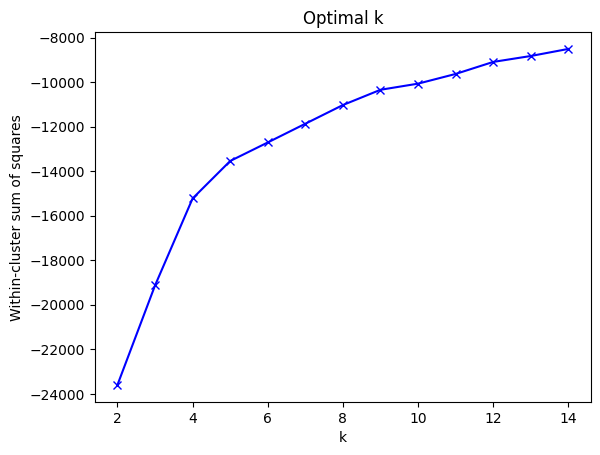

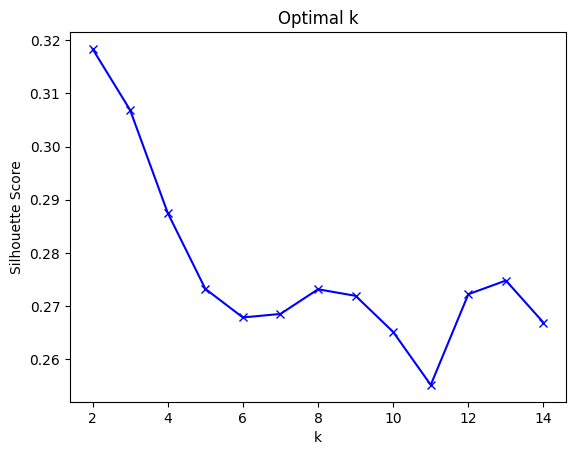

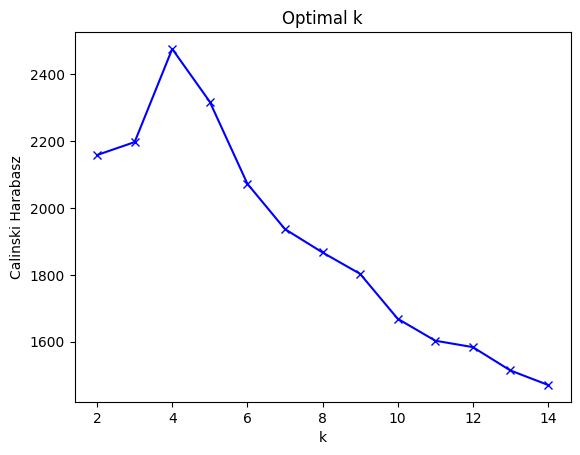

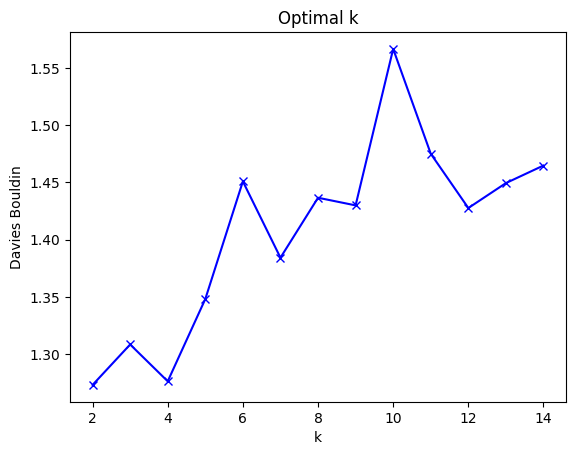

In [13]:
metrics_plots(X_train, max_k=15)

#### Results functions

In [3]:
def createColorMap(labels):
    unique_labels = np.unique(labels)
    cmap = cm.get_cmap('viridis', len(unique_labels))
    category_colors = {label: cmap(i) for i, label in enumerate(unique_labels)}
    return category_colors

def drawMap(data, labels, category_colors):
    gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(X_train_lat_long['longitude'], X_train_lat_long['latitude']))
    
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = world[(world.name != "Antarctica")]
    

    fig, ax = plt.subplots(figsize=(15, 7))
    world.plot(ax=ax, color='lightgray', edgecolor='white')
    
    for label, color in category_colors.items():
        subset = gdf[labels == label]
        subset.plot(ax=ax, marker='o', color=color, markersize=9, label=label)
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=color, markersize=9) 
                       for label, color in category_colors.items()]
    
    ax.legend(handles=legend_elements, loc='upper right', title='Cluster')
    
    plt.title('Businesses on World Map')
    plt.show()

def CountClusters(labels, category_colors):
    df = pd.DataFrame({"labels": labels})
    value_counts = df["labels"].value_counts()
        
    counts = value_counts.values
    clusters = value_counts.index

    plt.figure(figsize=(15, 6))
    bars = plt.bar(clusters, counts, color=[category_colors[c] for c in clusters])
    plt.title('Distribution of Clusters')
    plt.xlabel('Cluster Number')
    plt.ylabel('Number of Businesses')
    plt.show()

def calculateScores(data, labels):
    silhouette_avg = silhouette_score(data, labels)
    calinski_score = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    Scores = {
    'Score name': ['Silhouette Score', 'Calinski-Harabaz Index', 'Davies-Bouldin Index'],
    'score value': [silhouette_avg, calinski_score, davies_bouldin]
    }

    df_scores = pd.DataFrame(Scores)
    return df_scores

#### PCA

In [4]:
pca = PCA()
pca.fit(X_train)
pca.explained_variance_ratio_

array([2.77228342e-01, 2.41131524e-01, 1.60940527e-01, 8.26602690e-02,
       6.95761509e-02, 5.74958805e-02, 3.78361980e-02, 3.03915649e-02,
       1.42946551e-02, 1.37633643e-02, 7.21493823e-03, 6.20337587e-03,
       8.61664156e-04, 3.68472631e-04, 3.30733684e-05, 5.72336718e-33,
       2.69770470e-33, 2.52707042e-33])

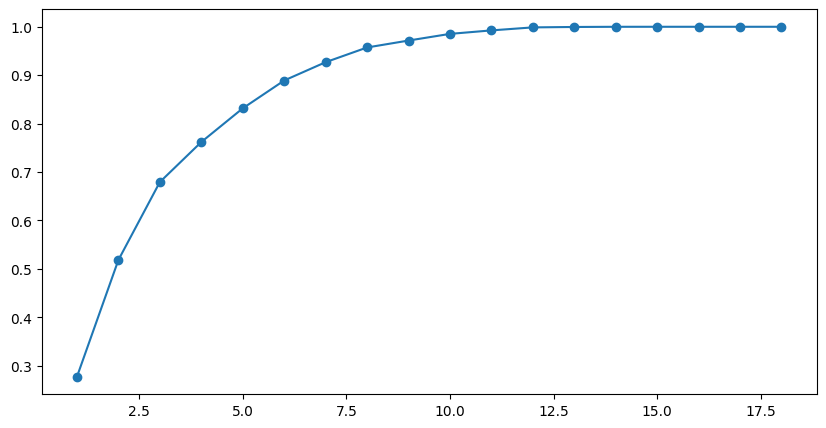

In [5]:
plt.figure(figsize = (10, 5))
plt.plot(range(1,19), pca.explained_variance_ratio_.cumsum(), marker = 'o')

In [6]:
pca = PCA(n_components=7)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [7]:
X_val_pca = pca.transform(X_val)

#### KMeans

In [9]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train_pca)
labels = kmeans.predict(X_train_pca)

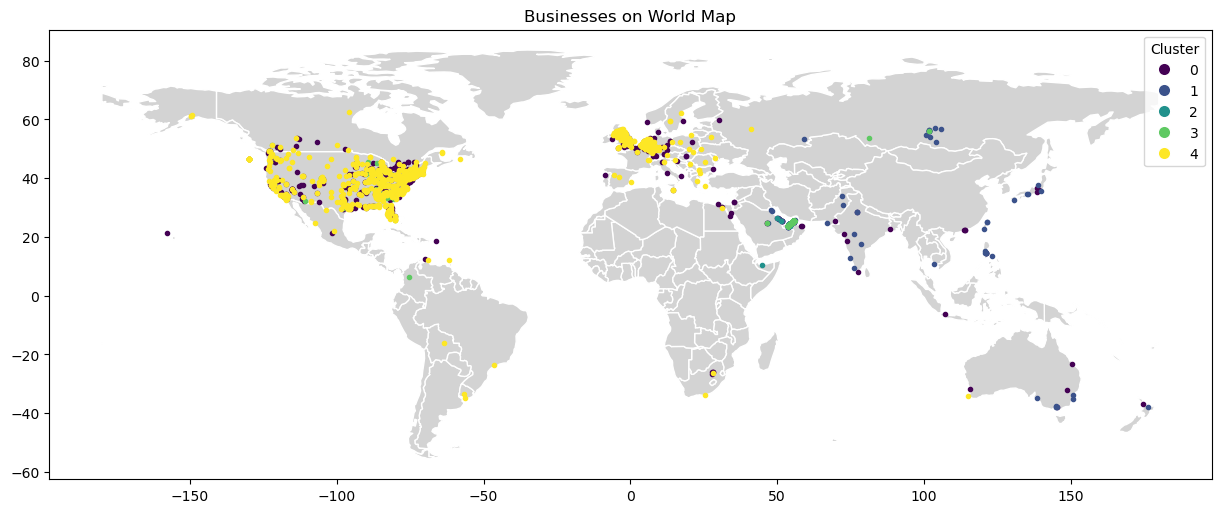

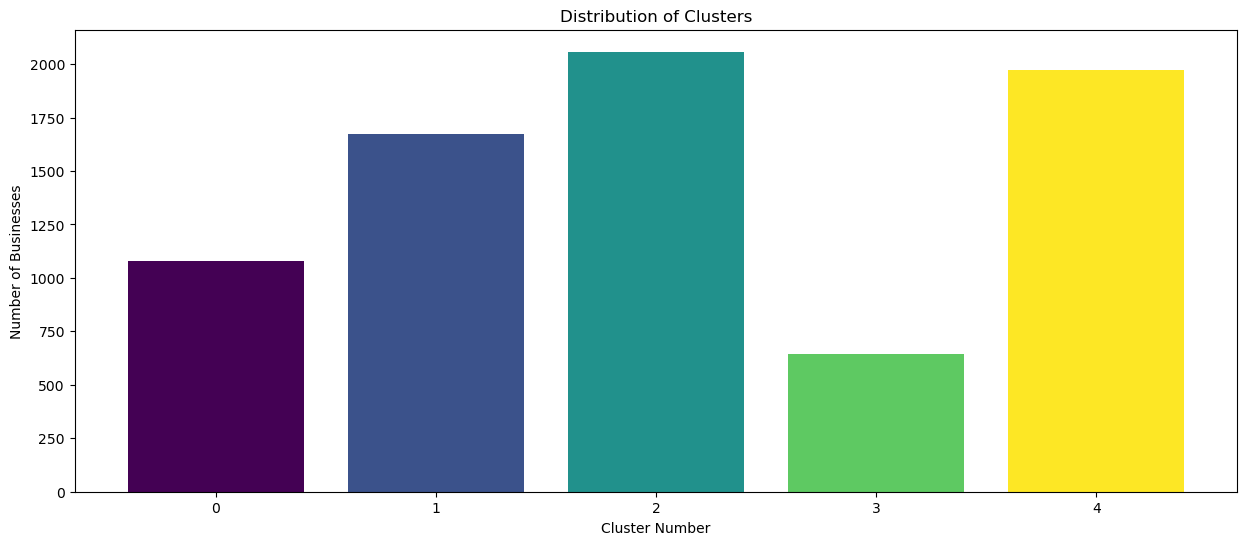

In [10]:
category_colors = createColorMap(labels)
drawMap(X_train_pca, labels, category_colors)
CountClusters(labels, category_colors)

In [11]:
calculateScores(X_train_pca, labels_kmeans)

,Score name,score value
0,Silhouette Score,0.305531
1,Calinski-Harabaz Index,2769.311557
2,Davies-Bouldin Index,1.204398


In [12]:
labels = kmeans.predict(X_val_pca)
calculateScores(X_val_pca, labels)

,Score name,score value
0,Silhouette Score,0.299523
1,Calinski-Harabaz Index,1161.897084
2,Davies-Bouldin Index,1.237226


#### KMedoids

In [77]:
medoids_model = KMedoids(n_clusters=5, random_state=0)
medoids_model.fit(X_train_pca)
labels = medoids_model.predict(X_train_pca)

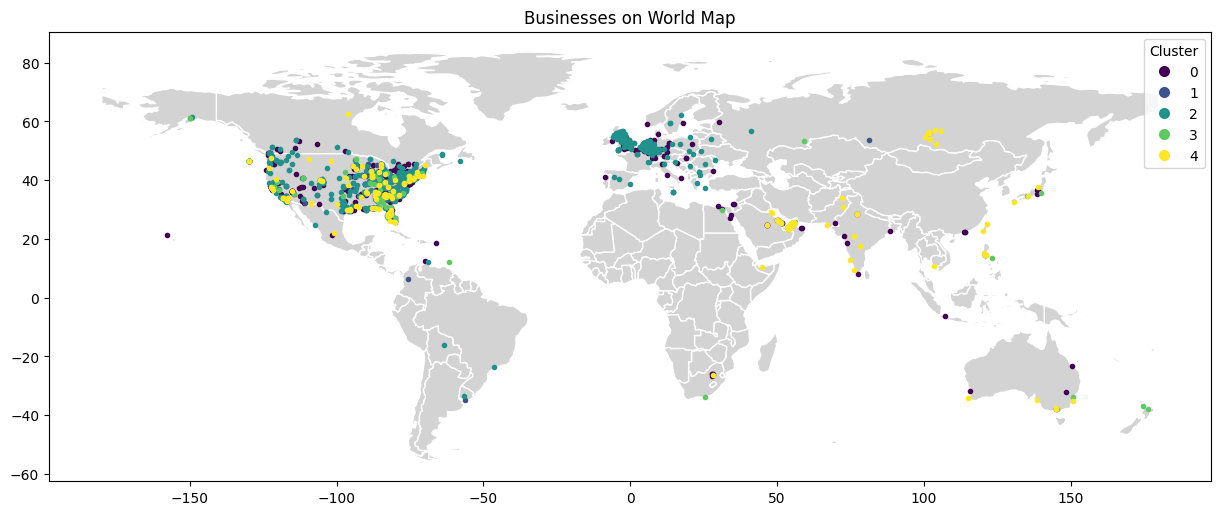

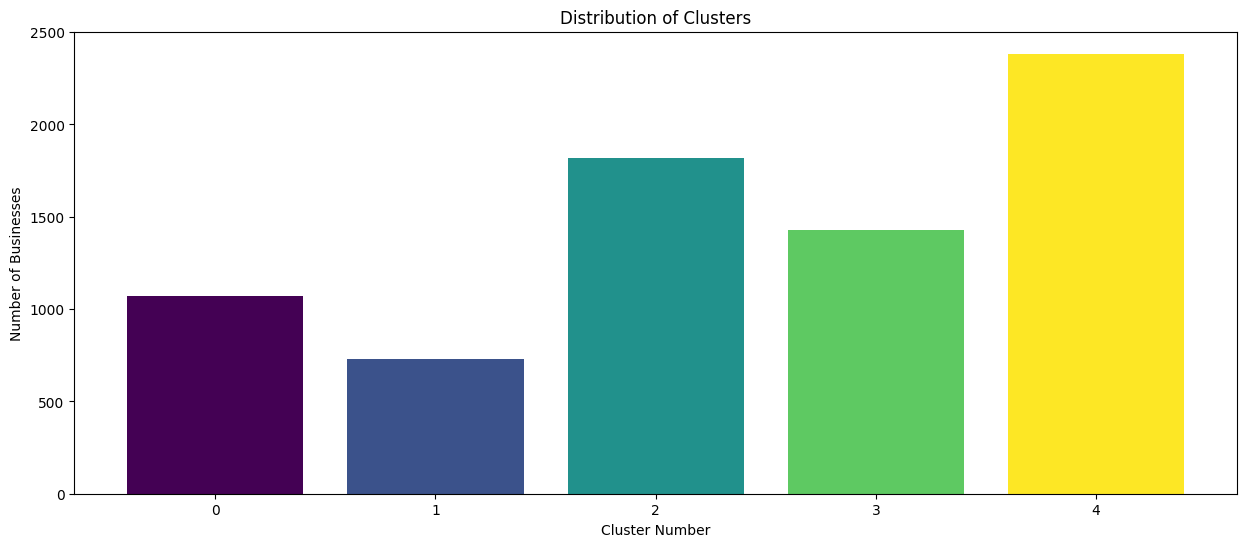

In [78]:
category_colors = createColorMap(labels)
drawMap(X_train_pca, labels, category_colors)
CountClusters(labels, category_colors)

In [79]:
calculateScores(X_train_pca, labels)

,Score name,score value
0,Silhouette Score,0.219552
1,Calinski-Harabaz Index,2350.689896
2,Davies-Bouldin Index,1.641599


In [80]:
labels = medoids_model.predict(X_val_pca)
calculateScores(X_val_pca, labels)

,Score name,score value
0,Silhouette Score,0.217005
1,Calinski-Harabaz Index,993.019666
2,Davies-Bouldin Index,1.657660


### Hierarchic models

In [74]:
def linkageGraph(data, method):
    Z = hierarchy.linkage(data, method=method)
    plt.figure(figsize=(10, 20), dpi= 200, facecolor='w', edgecolor='k')
    hierarchy.dendrogram(Z)
    plt.show()
    return Z

#### Single Linkage

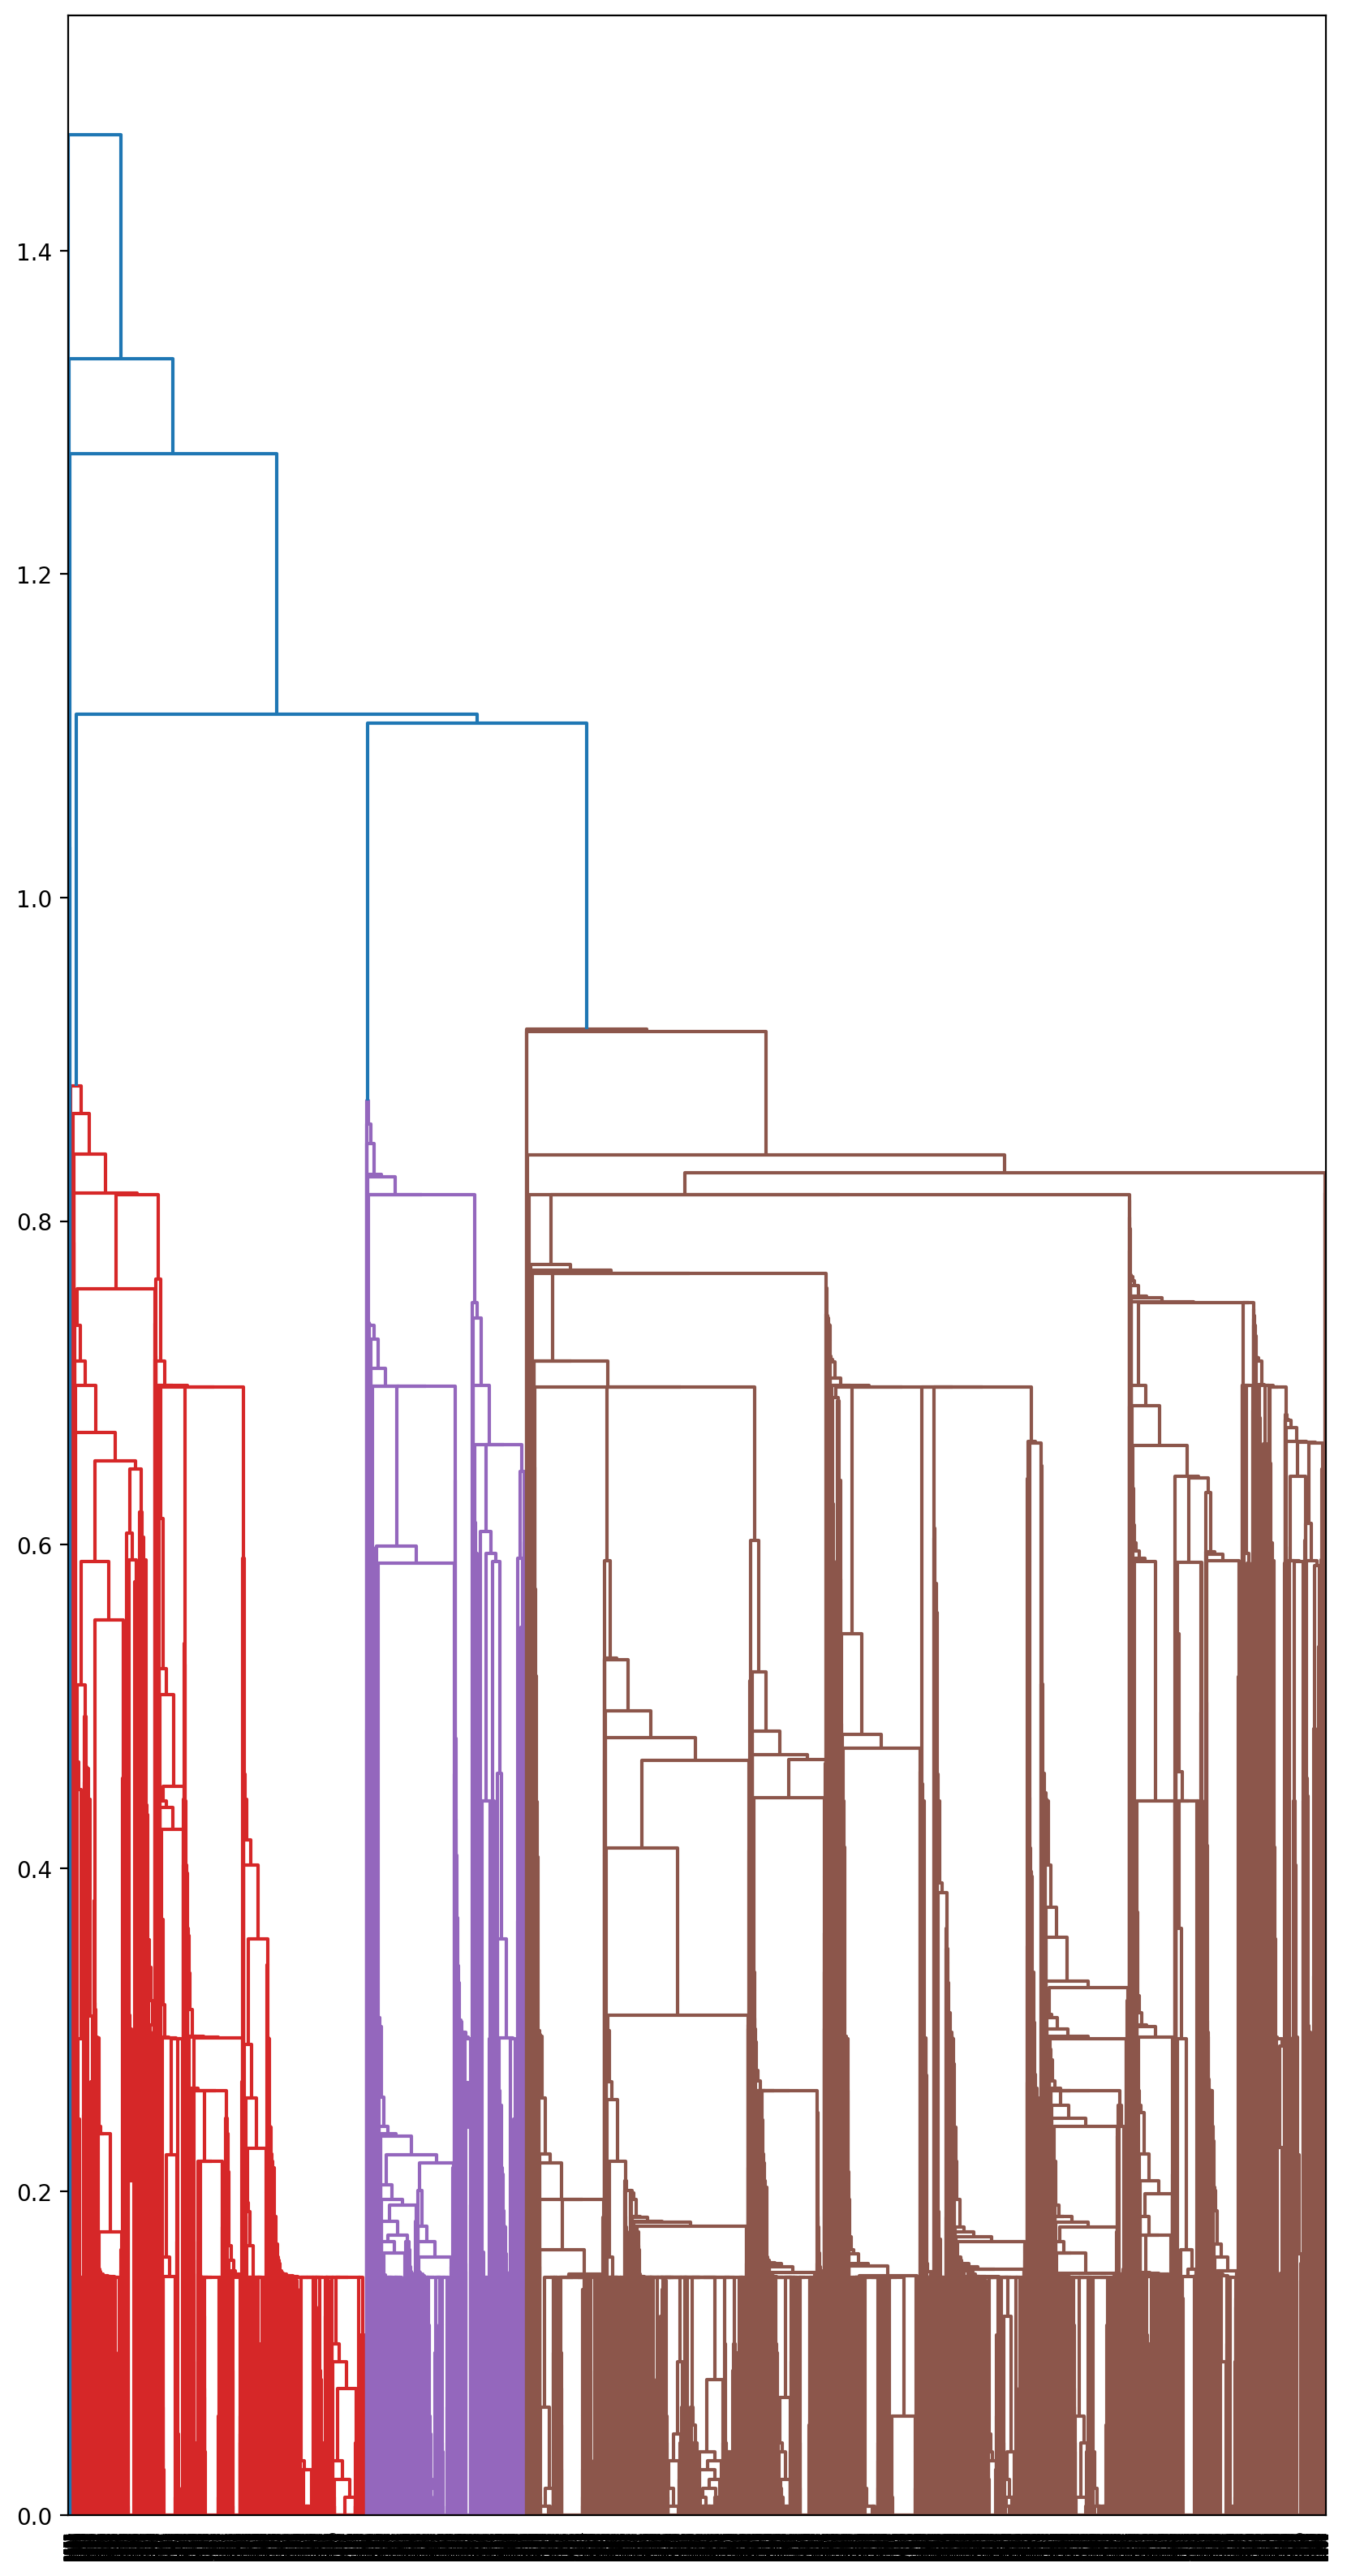

In [17]:
Z = linkageGraph(X_train_pca, 'single')

In [81]:
model = AgglomerativeClustering(n_clusters=None, linkage='single', distance_threshold=1.1)
labels = model.fit_predict(X_train_pca)

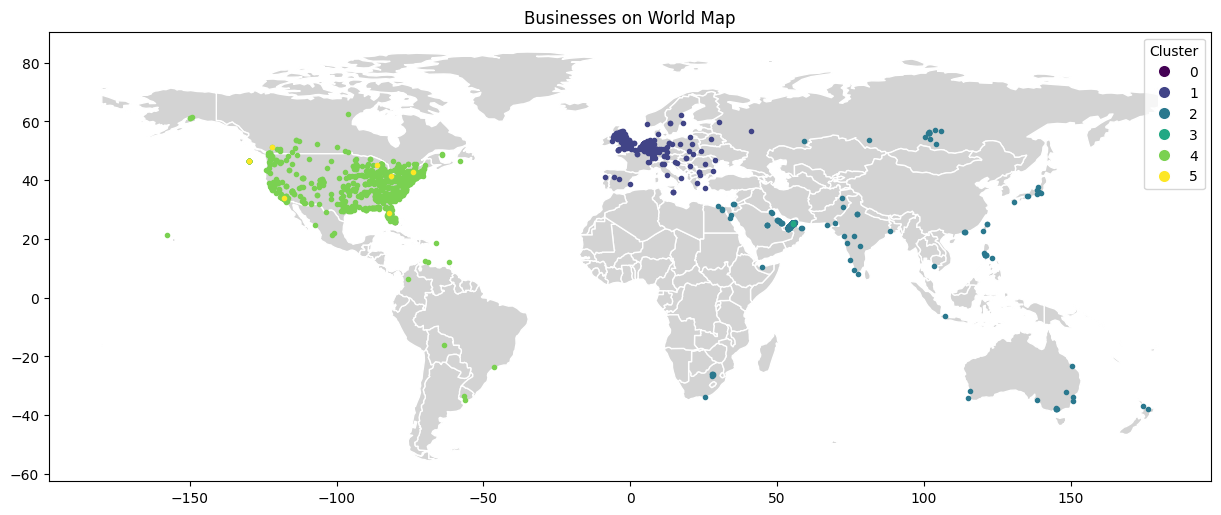

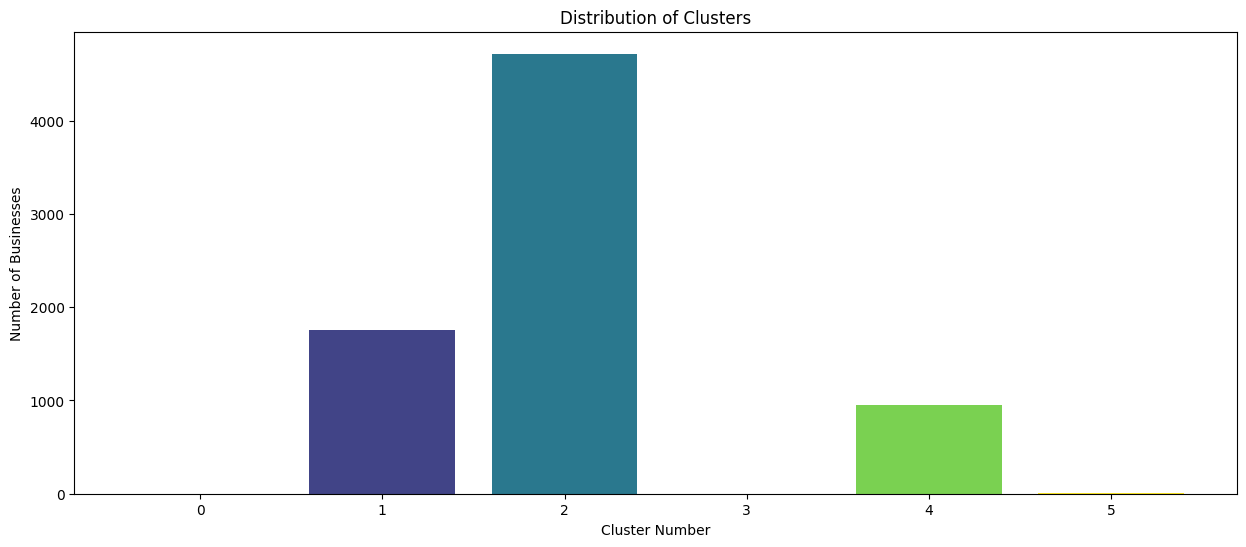

In [82]:
category_colors = createColorMap(labels)
drawMap(X_train_pca, labels, category_colors)
CountClusters(labels, category_colors)

In [83]:
calculateScores(X_train_pca, labels)

,Score name,score value
0,Silhouette Score,0.203169
1,Calinski-Harabaz Index,515.144756
2,Davies-Bouldin Index,1.126414


#### Complete Linkage

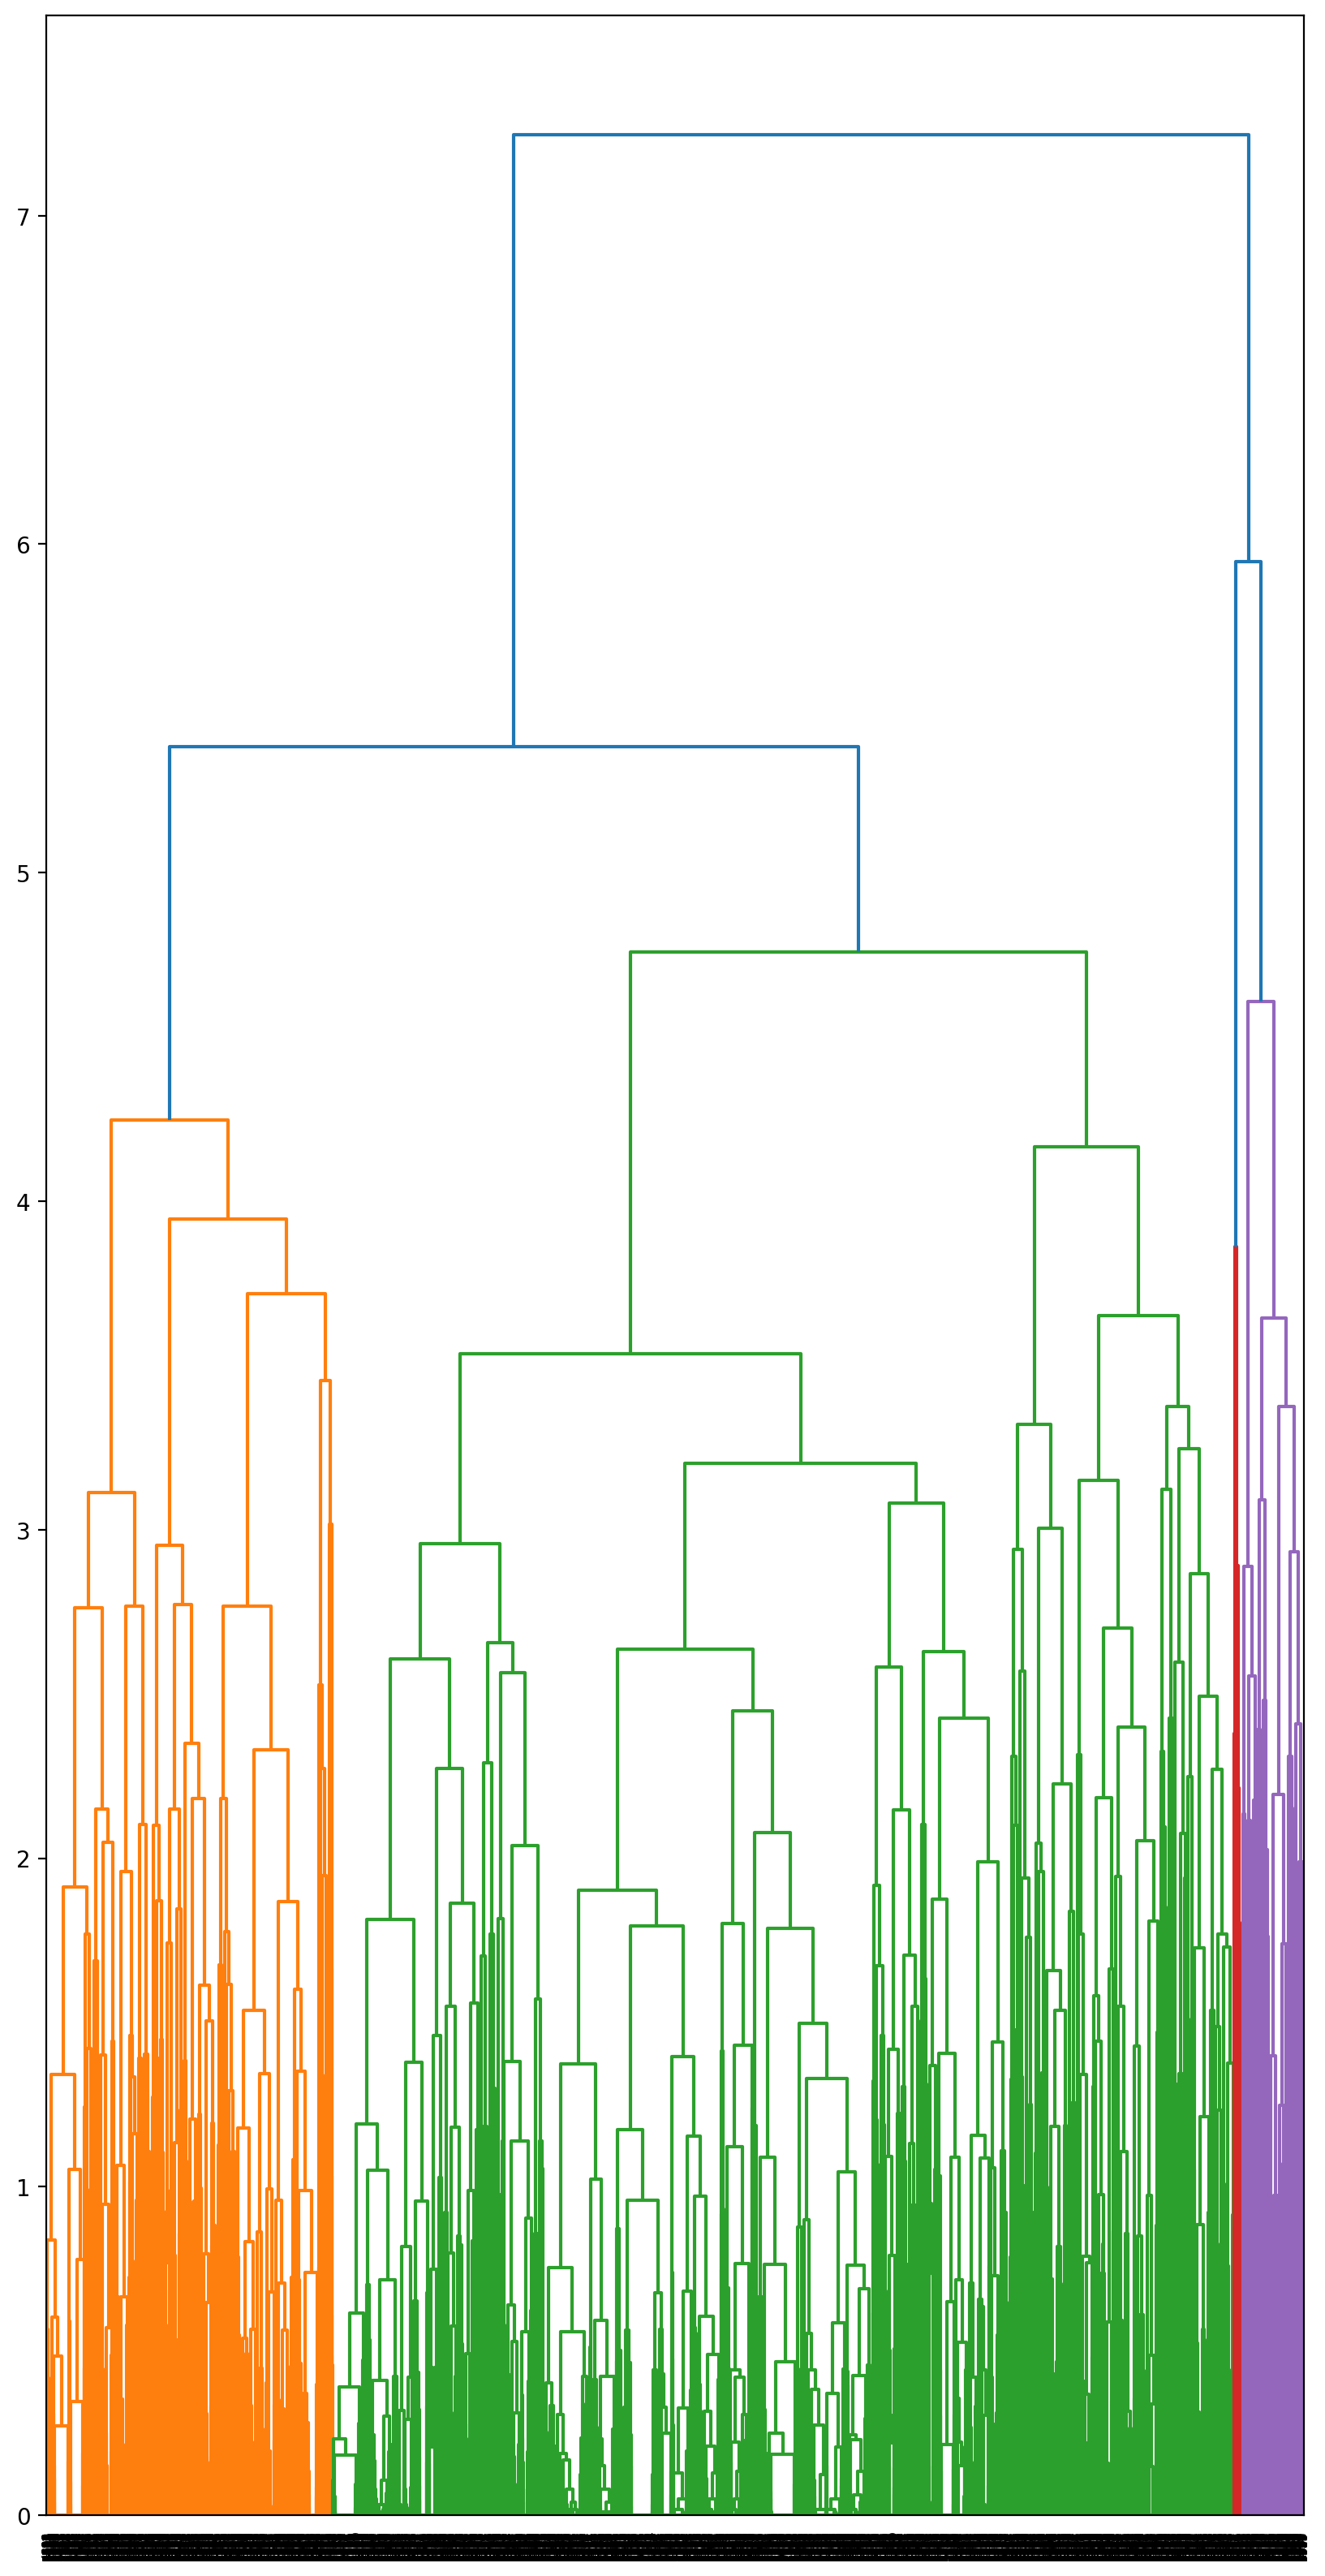

In [45]:
Z = linkageGraph(X_train_pca, 'complete')

In [14]:
model = AgglomerativeClustering(n_clusters=None, linkage='complete', distance_threshold=5)
labels_complete = model.fit_predict(X_train_pca)

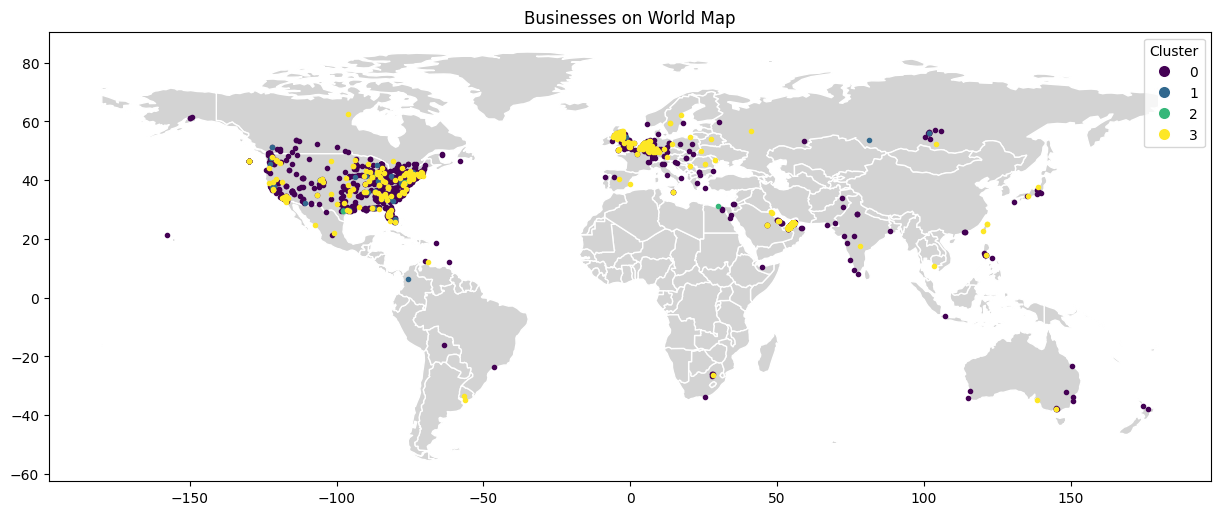

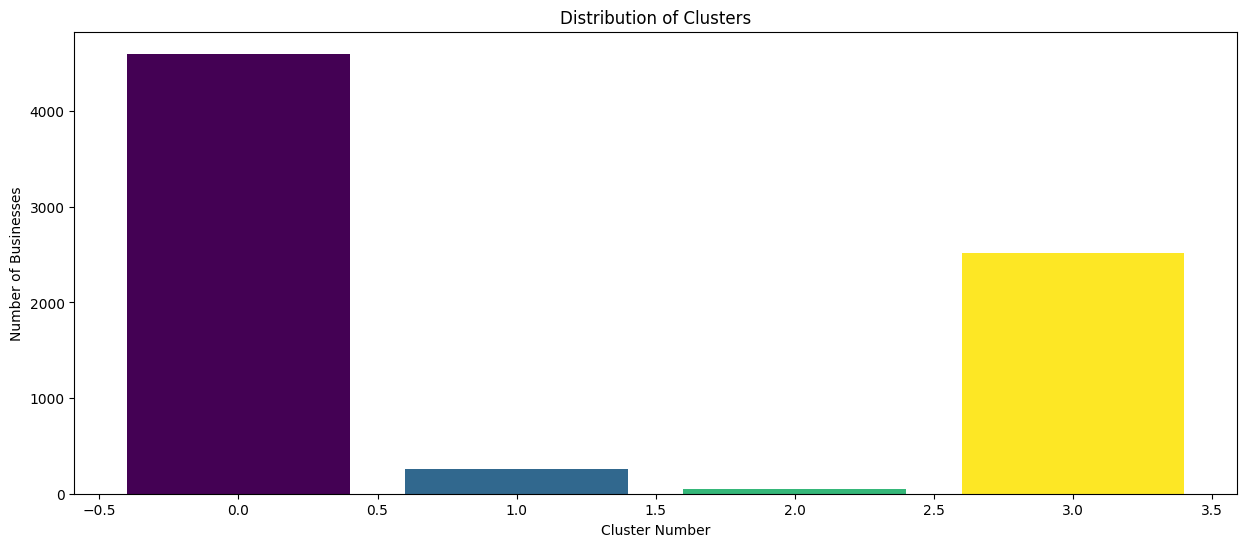

In [16]:
category_colors = createColorMap(labels_complete)
drawMap(X_train_pca, labels_complete, category_colors)
CountClusters(labels_complete, category_colors)

In [18]:
calculateScores(X_train_pca, labels_complete)

,Score name,score value
0,Silhouette Score,0.041745
1,Calinski-Harabaz Index,664.567169
2,Davies-Bouldin Index,1.924996


#### Average Linkage

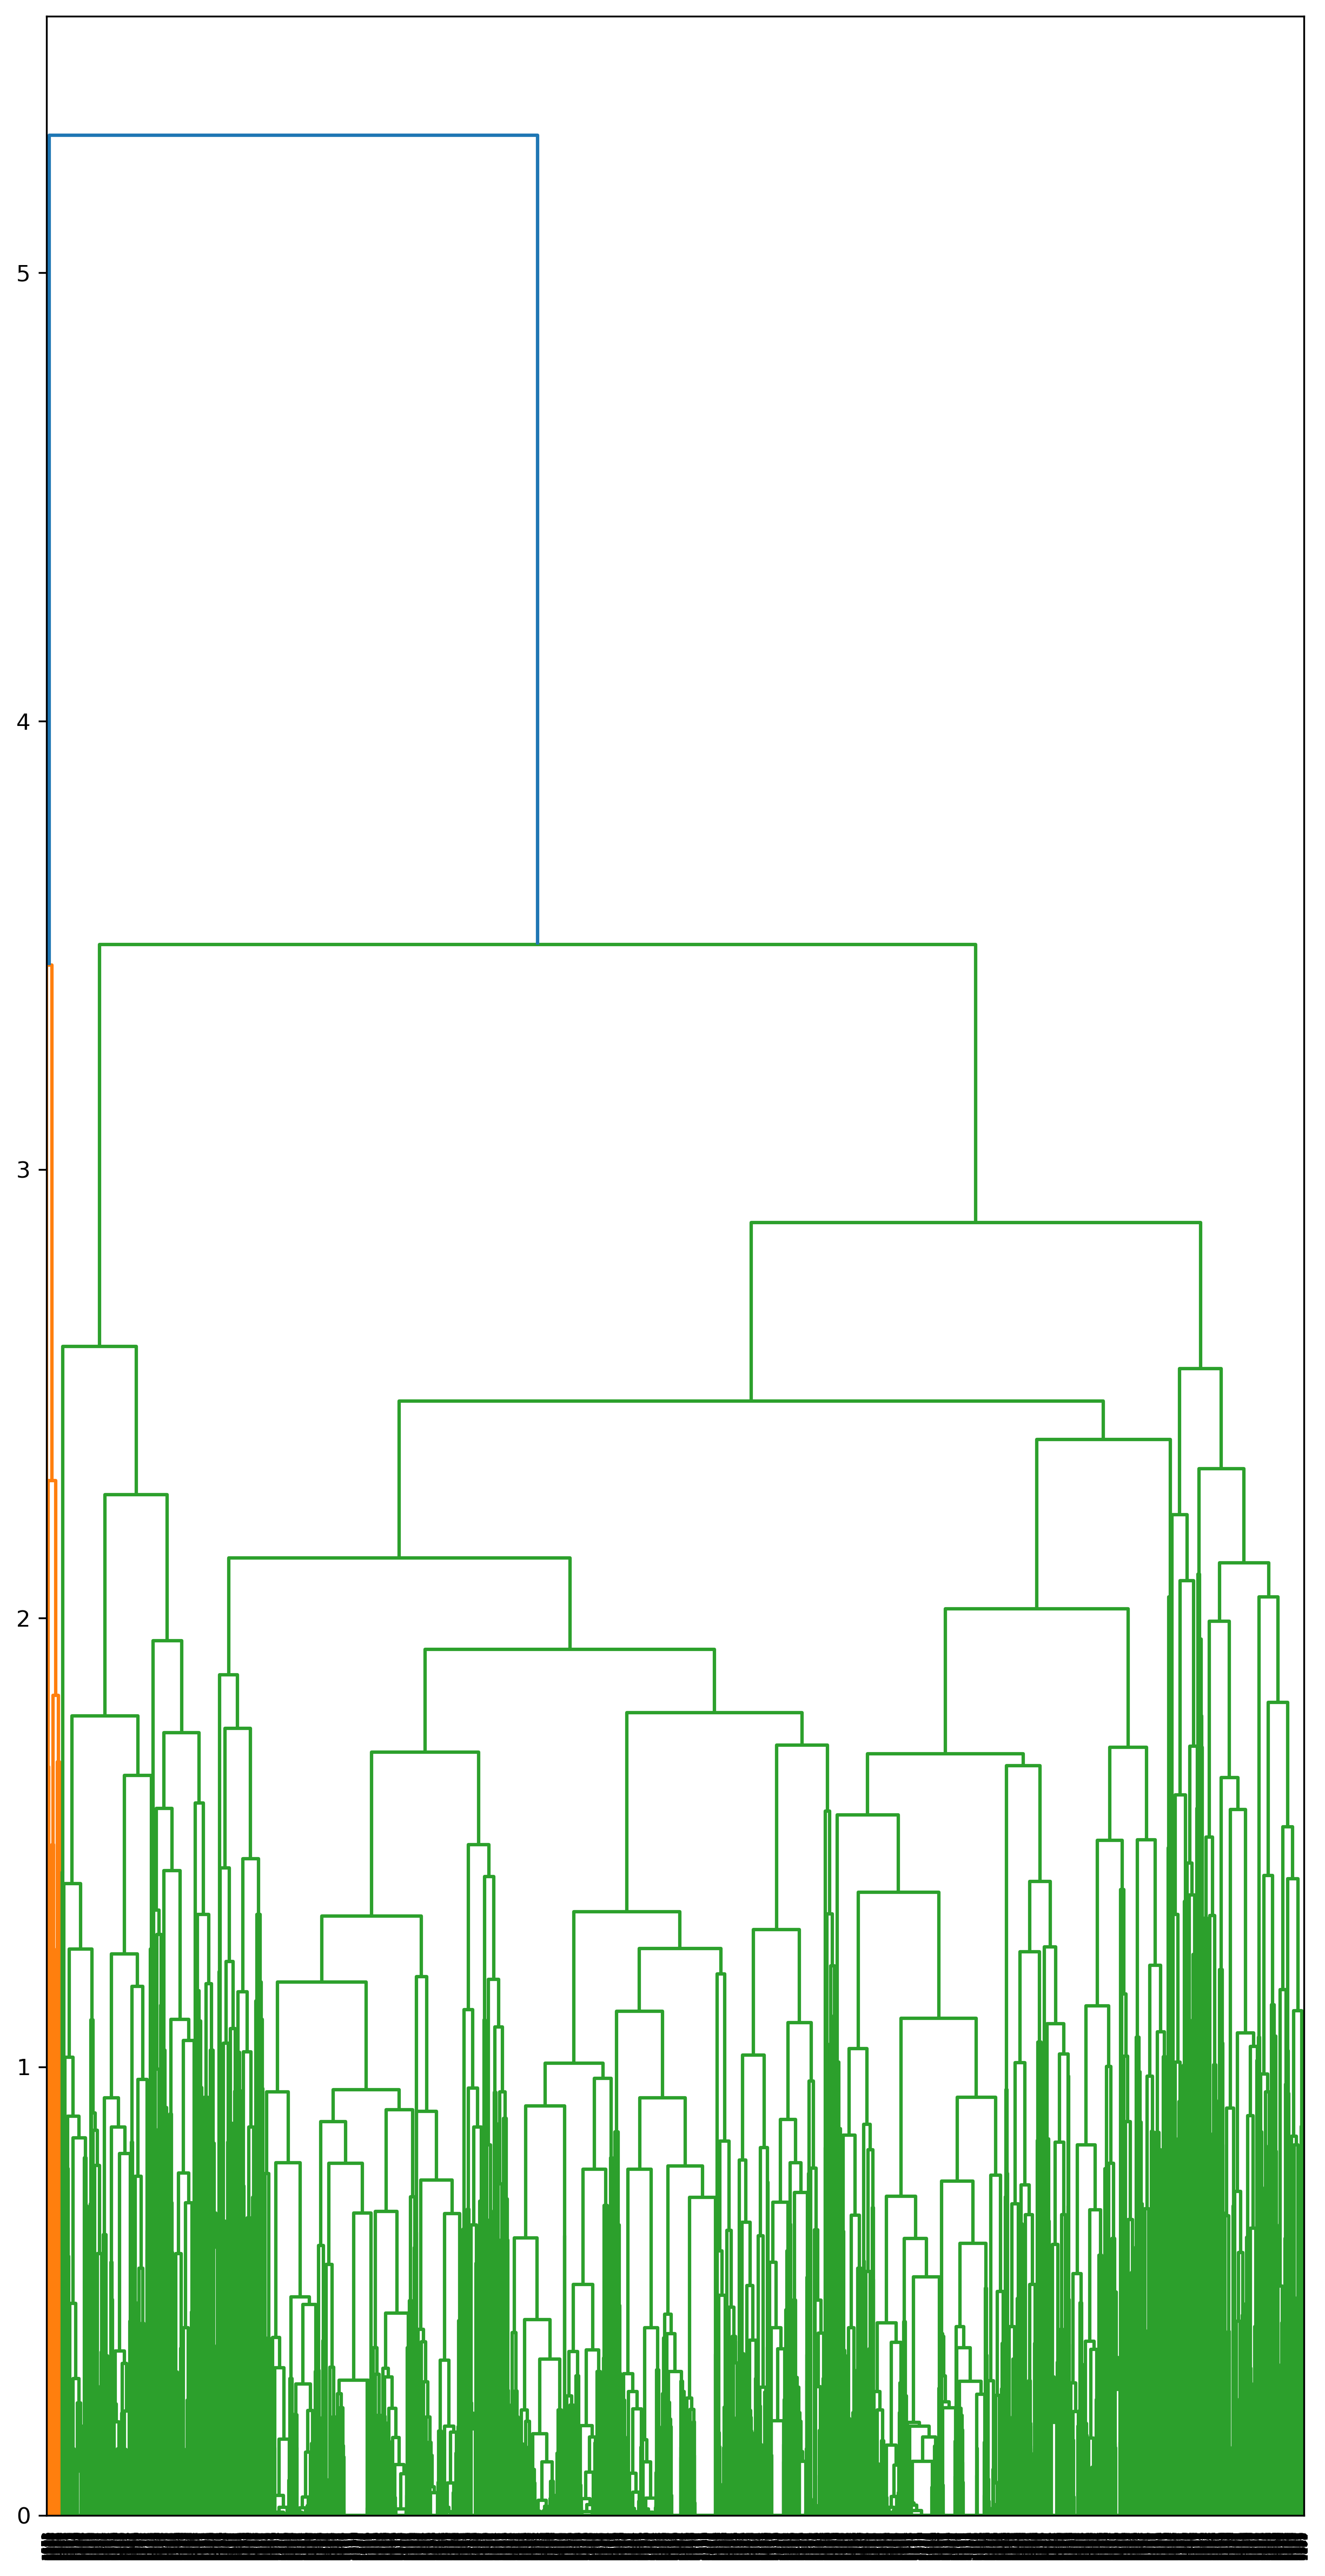

In [75]:
Z = linkageGraph(X_train_pca, 'average')

In [19]:
model = AgglomerativeClustering(n_clusters=None, linkage='average', distance_threshold=3)
labels_av = model.fit_predict(X_train_pca)

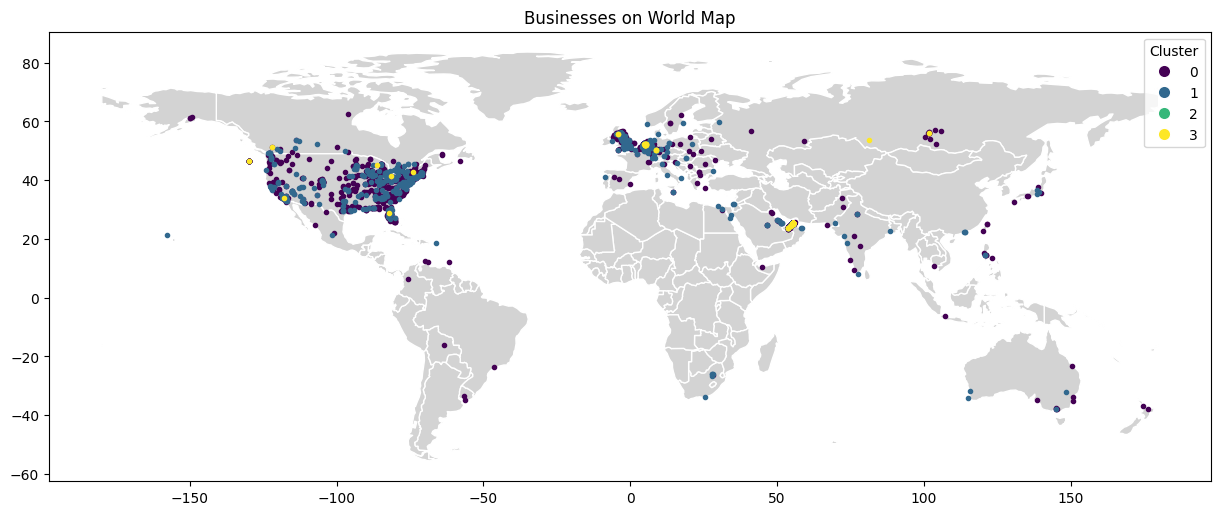

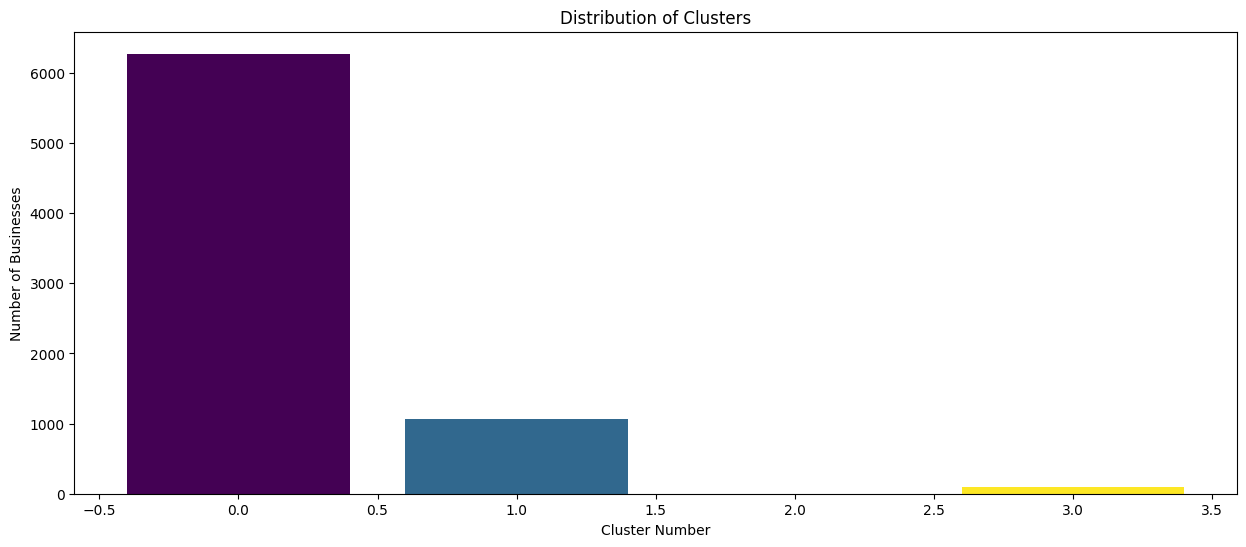

In [20]:
category_colors = createColorMap(labels_av)
drawMap(X_train_pca, labels_av, category_colors)
CountClusters(labels_av, category_colors)

In [21]:
calculateScores(X_train_pca, labels_av)

,Score name,score value
0,Silhouette Score,0.334103
1,Calinski-Harabaz Index,1081.059905
2,Davies-Bouldin Index,0.861015


#### Ward's Linkage

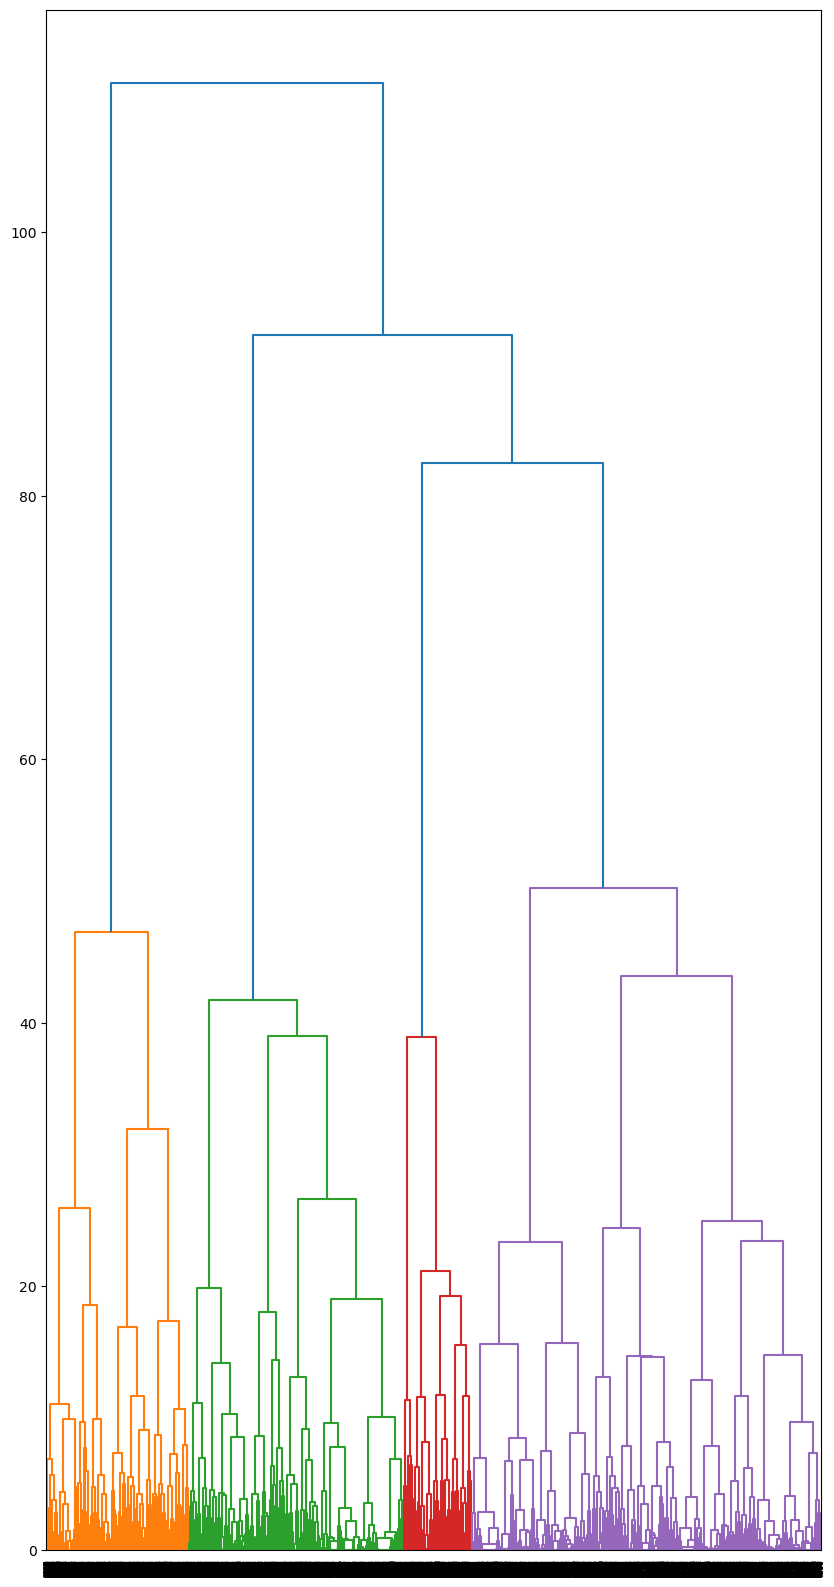

In [69]:
Z = linkageGraph(X_train_pca, 'ward')

In [70]:
model = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=60)
labels = model.fit_predict(X_train_pca)

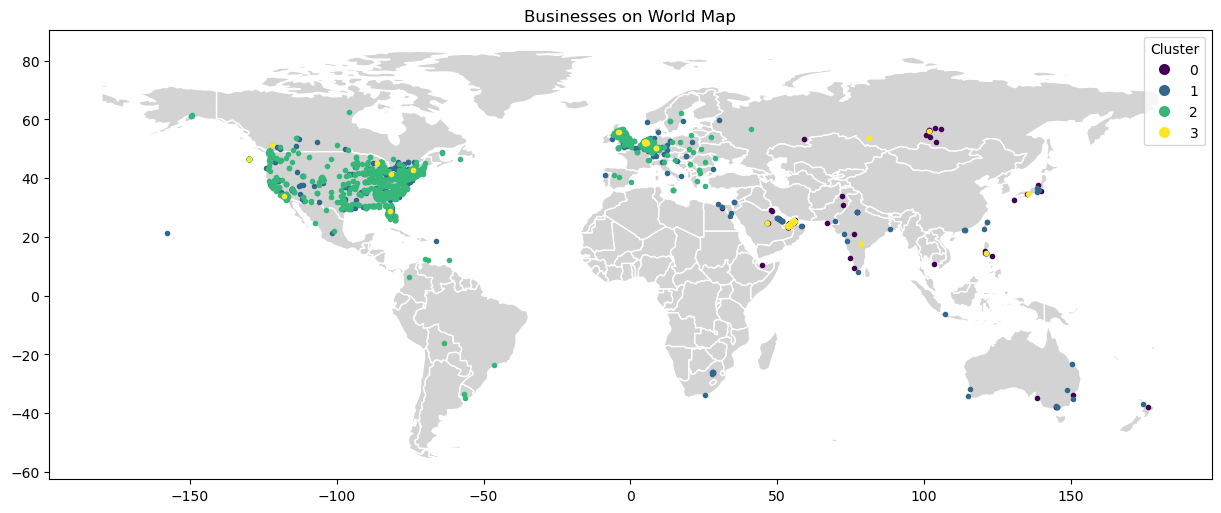

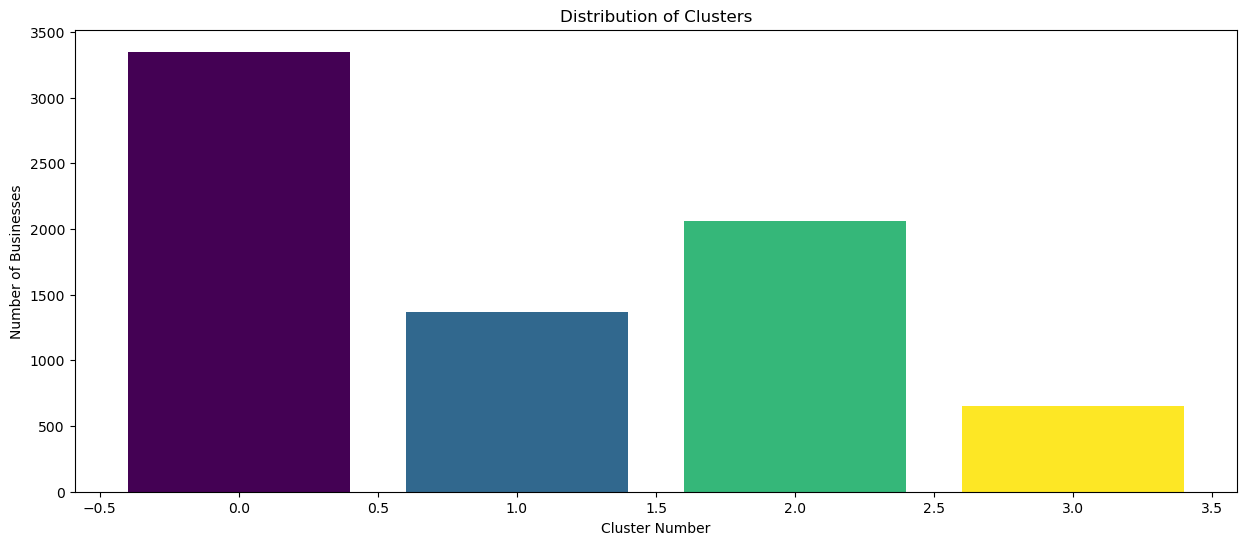

In [71]:
category_colors = createColorMap(labels)
drawMap(X_train_pca, labels, category_colors)
CountClusters(labels, category_colors)

In [72]:
calculateScores(X_train_pca, labels)

,Score name,score value
0,Silhouette Score,0.287645
1,Calinski-Harabaz Index,2380.876503
2,Davies-Bouldin Index,1.261915


#### MiniBatchKMeans

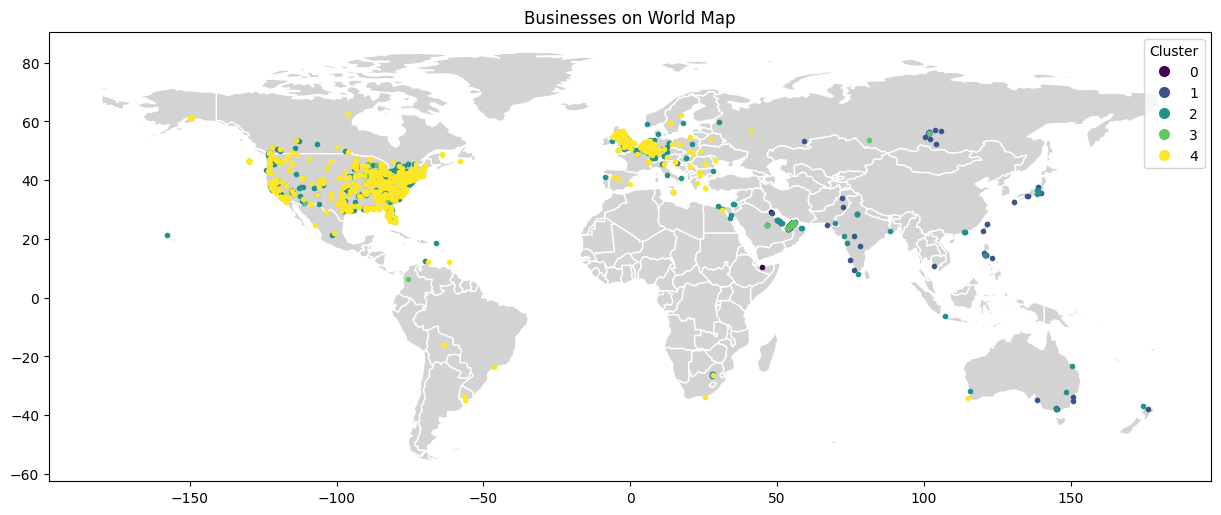

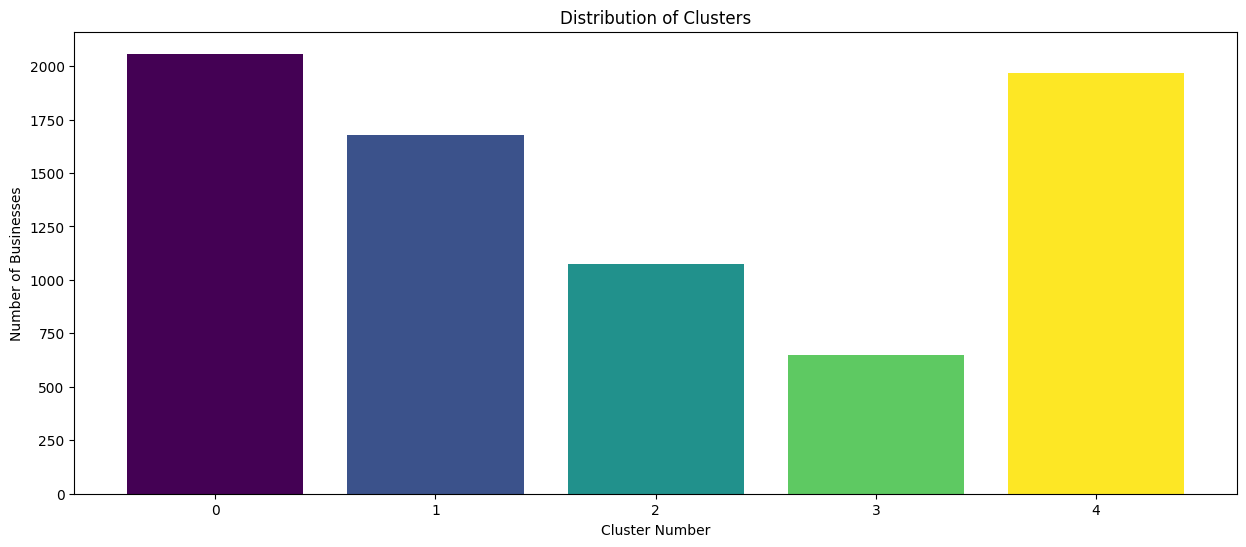

In [25]:
miniBatchKmeans = MiniBatchKMeans(n_clusters=5)
miniBatchKmeans.fit(X_train_pca)
labels_mini = miniBatchKmeans.predict(X_train_pca)
category_colors = createColorMap(labels_mini)
drawMap(X_train_pca, labels_mini, category_colors)
CountClusters(labels_mini, category_colors)

In [26]:
calculateScores(X_train_pca, labels_mini)

,Score name,score value
0,Silhouette Score,0.305724
1,Calinski-Harabaz Index,2768.237318
2,Davies-Bouldin Index,1.205923


In [27]:
labels = miniBatchKmeans.predict(X_val_pca)
calculateScores(X_val_pca, labels)

,Score name,score value
0,Silhouette Score,0.299636
1,Calinski-Harabaz Index,1161.782683
2,Davies-Bouldin Index,1.234791


#### DBScan

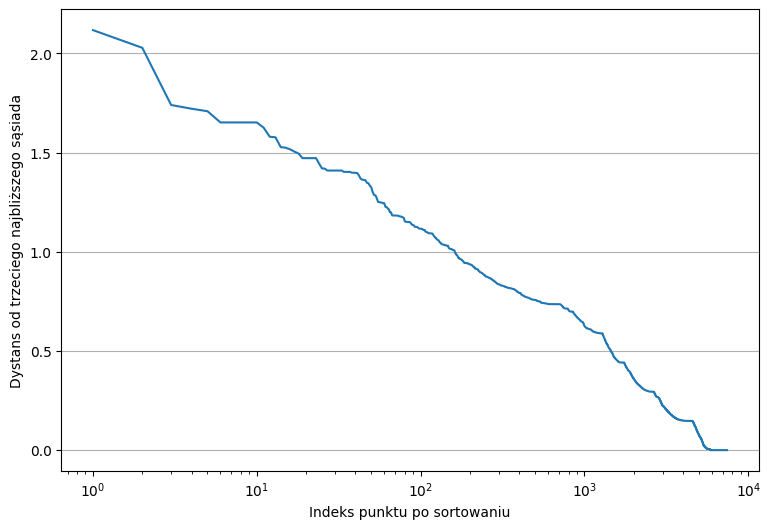

In [58]:
minPts = 14
nbrs = NearestNeighbors(n_neighbors=minPts).fit(X_train_pca)
distances, indices = nbrs.kneighbors(X_train_pca)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,X_train_pca.shape[0]+1)), distanceDec)

plt.xscale('log')
plt.grid(axis='y')

plt.show()

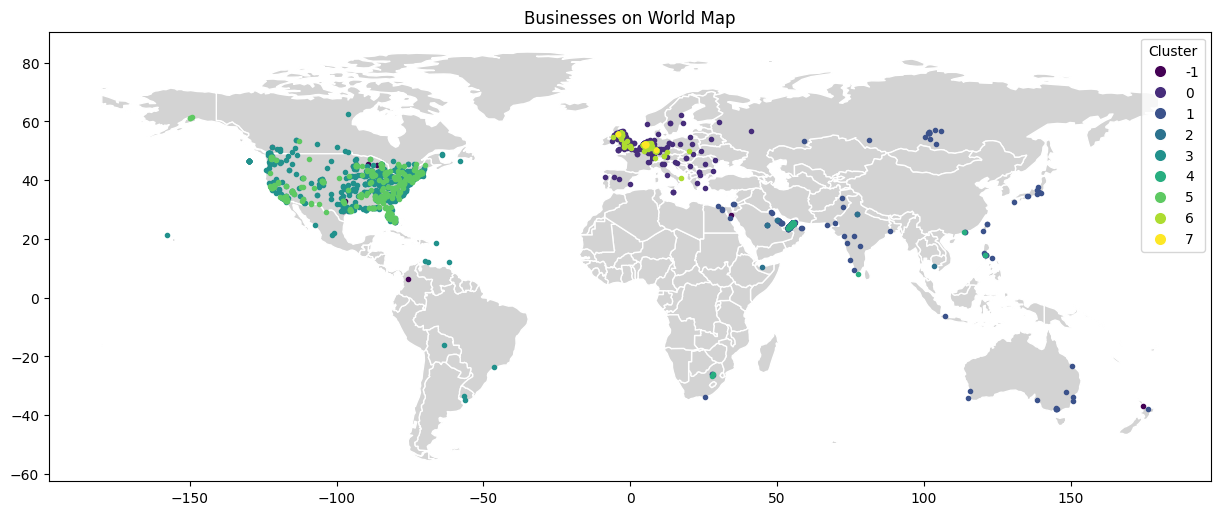

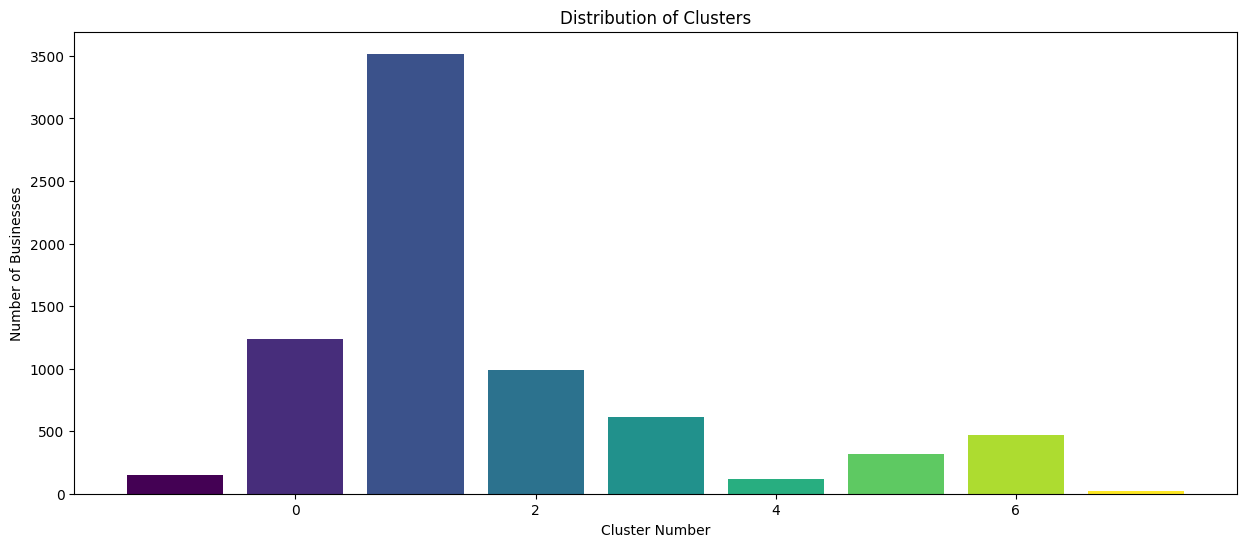

,Score name,score value
0,Silhouette Score,0.139947
1,Calinski-Harabaz Index,621.679439
2,Davies-Bouldin Index,1.792859


In [57]:
dbs = DBSCAN(min_samples = 14, eps = 0.8)
dbs.fit(X_train_pca)
labels = dbs.labels_
category_colors = createColorMap(labels)
drawMap(X_train_pca, labels, category_colors)
CountClusters(labels, category_colors)
calculateScores(X_train_pca, labels)

#### Gaussian Mixture Models

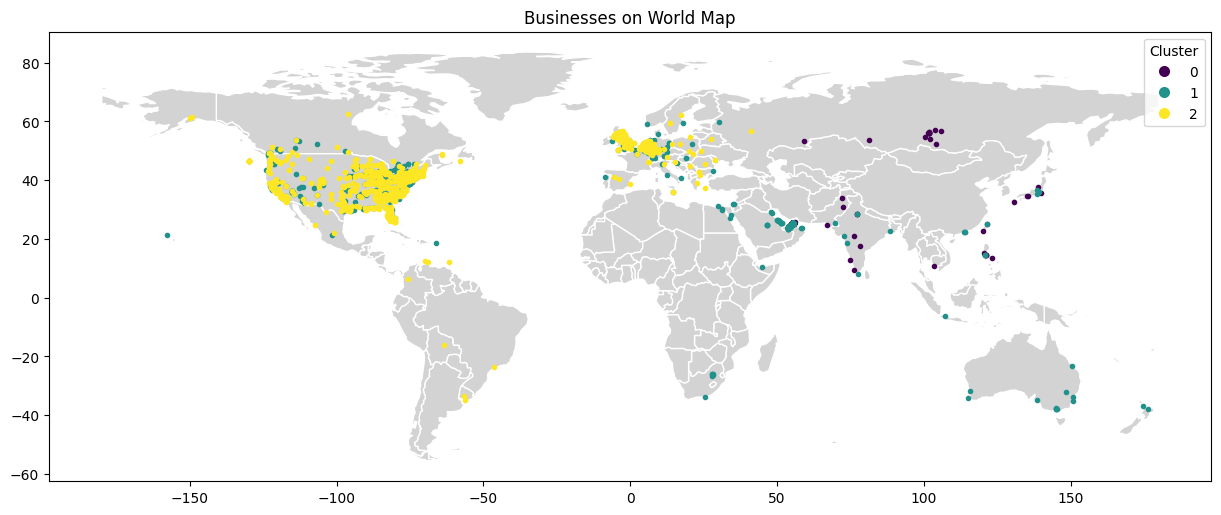

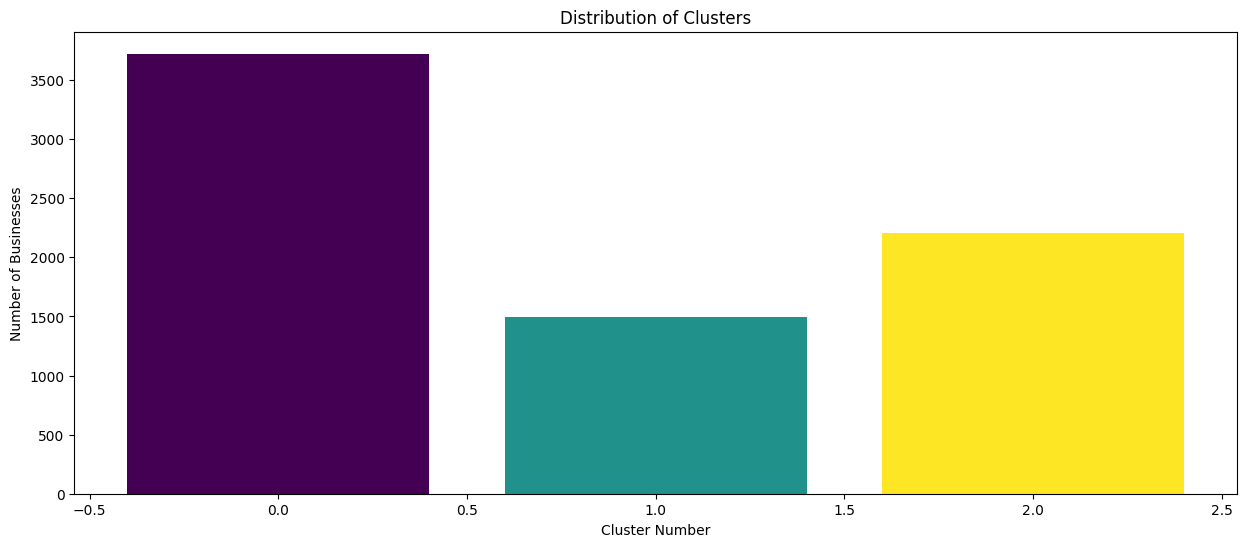

,Score name,score value
0,Silhouette Score,0.240091
1,Calinski-Harabaz Index,1648.915751
2,Davies-Bouldin Index,1.586987


In [11]:
gmm = GaussianMixture(n_components = 3)
gmm.fit(X_train_pca)
labels_gmm = gmm.predict(X_train_pca)
category_colors = createColorMap(labels_gmm)
drawMap(X_train_pca, labels_gmm, category_colors)
CountClusters(labels_gmm, category_colors)
calculateScores(X_train_pca, labels_gmm)

In [13]:
labels_gmm_val = gmm.predict(X_val_pca)
calculateScores(X_val_pca, labels_gmm_val)

,Score name,score value
0,Silhouette Score,0.120867
1,Calinski-Harabaz Index,422.689053
2,Davies-Bouldin Index,4.000985


### Interpretation for best models

##### k-means

In [8]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train_pca)
labels_kmeans = kmeans.predict(X_train_pca)
labels_kmeans_val = kmeans.predict(X_val_pca)

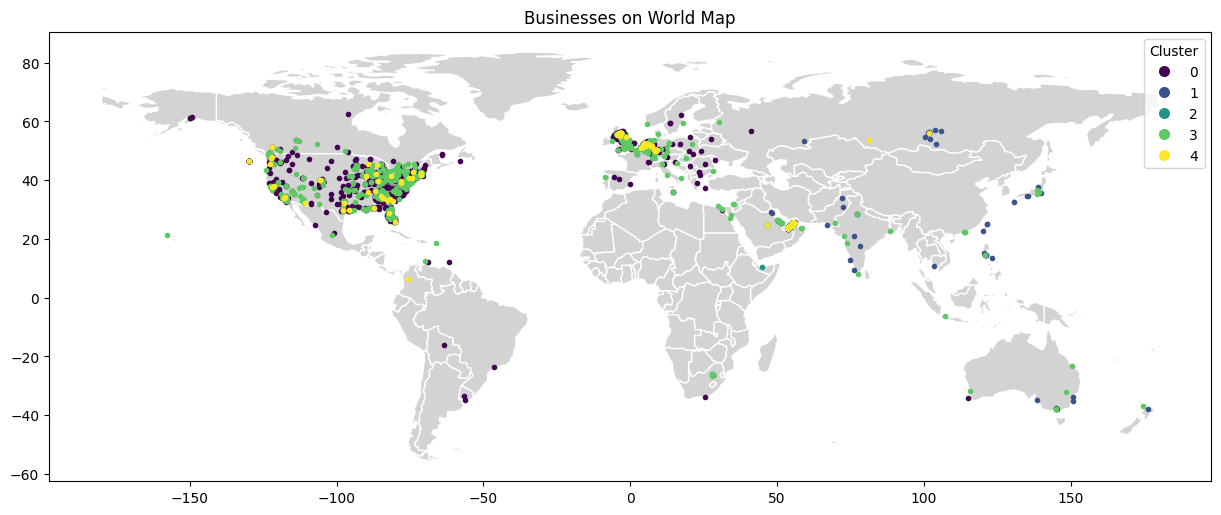

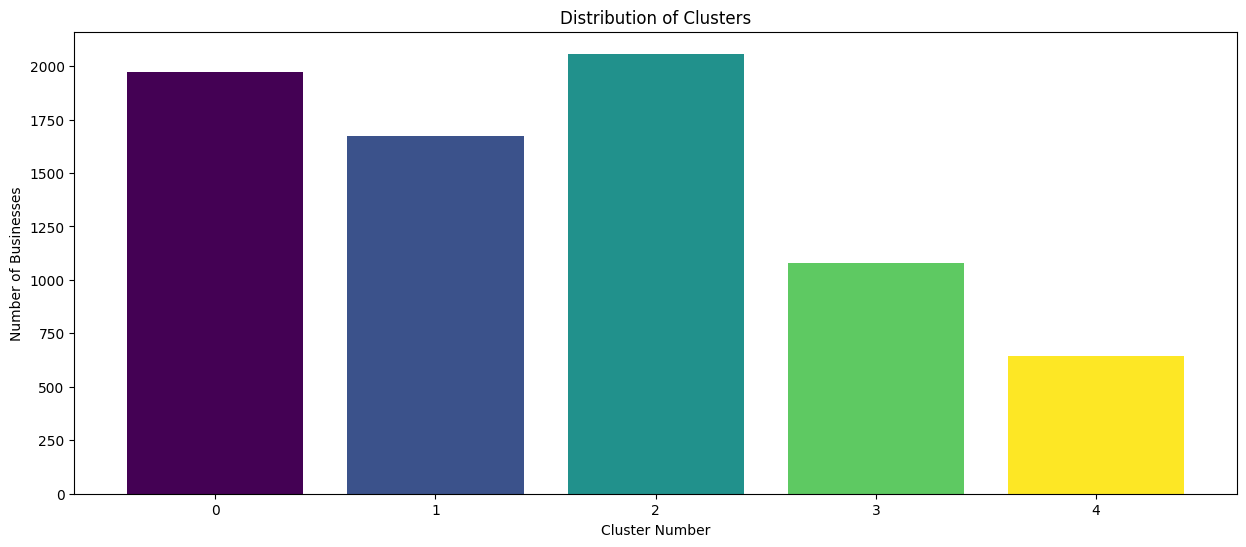

In [9]:
category_colors = createColorMap(labels_kmeans)
drawMap(X_train_pca, labels_kmeans, category_colors)
CountClusters(labels_kmeans, category_colors)

In [21]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, labels_kmeans)
labels_kmeans_pred = rf.predict(X_val)

accuracy = accuracy_score(labels_kmeans_val, labels_kmeans_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.99


In [22]:
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

                     Feature  Importance
0          num__review_count    0.253232
1                num__rating    0.178003
13        cat__cluster_geo_1    0.160070
15        cat__cluster_geo_3    0.113183
4        cat__continent_Asia    0.104198
14        cat__cluster_geo_2    0.101886
6      cat__continent_Europe    0.034554
12        cat__cluster_geo_0    0.011325
3     cat__continent_America    0.010677
17    remainder__has_website    0.009970
8        cat__cluster_type_1    0.005498
11       cat__cluster_type_4    0.004933
10       cat__cluster_type_3    0.004704
16       remainder__verified    0.003398
9        cat__cluster_type_2    0.002902
7        cat__cluster_type_0    0.000810
2      cat__continent_Africa    0.000376
5   cat__continent_Australia    0.000281


As we can see the most important feature in our model is related to rating.

In [23]:
X_train1 = X_train.copy()
X_train1['cluster'] = labels_kmeans

In [24]:
grouped_X_train1 = X_train1[['cat__cluster_type_0', 'cat__cluster_type_1', 'cat__cluster_type_2', 
                            'cat__cluster_type_3', 'cat__cluster_type_4', 'cluster']].groupby('cluster').sum()
print("\nGrouped and Summed DataFrame:")
print(grouped_X_train1)


Grouped and Summed DataFrame:
         cat__cluster_type_0  cat__cluster_type_1  cat__cluster_type_2  \
cluster                                                                  
0                        2.0                130.0                111.0   
1                       46.0                169.0                 46.0   
2                       29.0                556.0                 33.0   
3                       30.0                107.0                  3.0   
4                       90.0                390.0                 49.0   

         cat__cluster_type_3  cat__cluster_type_4  
cluster                                            
0                      120.0                716.0  
1                       11.0               1402.0  
2                       15.0               1425.0  
3                       17.0                486.0  
4                       45.0               1397.0  


In [10]:
df = pd.read_csv('./DATA/X_train_clean.csv')
unique_labels = np.unique(labels_kmeans)

for label in unique_labels:
    cluster_data = df[labels_kmeans == label]
    cluster_mean = cluster_data.mean()
    cluster_median = cluster_data.median()
    cluster_std = cluster_data.std()
    
    print(f"Cluster {label} Summary:")
    print("Mean:")
    print(cluster_mean)
    print("Median:")
    print(cluster_median)
    print("Standard Deviation:")
    print(cluster_std)
    print("\n")

Cluster 0 Summary:
Mean:
cat__continent_Africa        0.001522
cat__continent_America       0.293252
cat__continent_Asia          0.000000
cat__continent_Australia     0.000507
cat__continent_Europe        0.704718
cat__cluster_type_0          0.650431
cat__cluster_type_1          0.089295
cat__cluster_type_2          0.198376
cat__cluster_type_3          0.037037
cat__cluster_type_4          0.024860
cat__cluster_geo_0           0.002029
cat__cluster_geo_1           0.000000
cat__cluster_geo_2           0.997971
cat__cluster_geo_3           0.000000
remainder__latitude         47.771001
remainder__longitude       -22.893360
remainder__review_count     52.520041
remainder__rating            4.459107
remainder__verified          0.696601
remainder__has_website       0.741248
dtype: float64
Median:
cat__continent_Africa        0.000000
cat__continent_America       0.000000
cat__continent_Asia          0.000000
cat__continent_Australia     0.000000
cat__continent_Europe        1.000000
ca

##### Gaussian Mixture Models

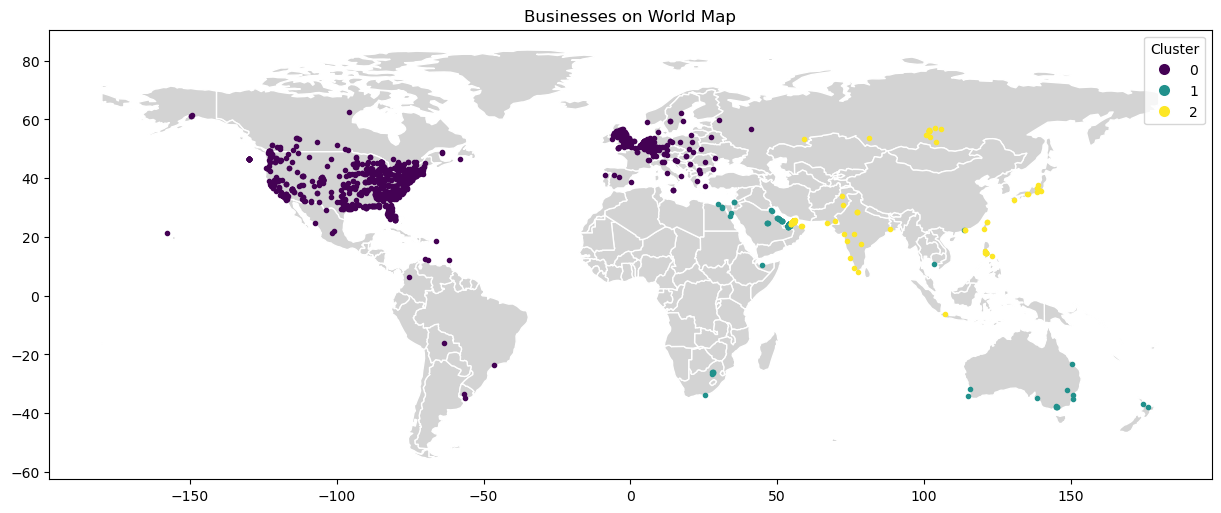

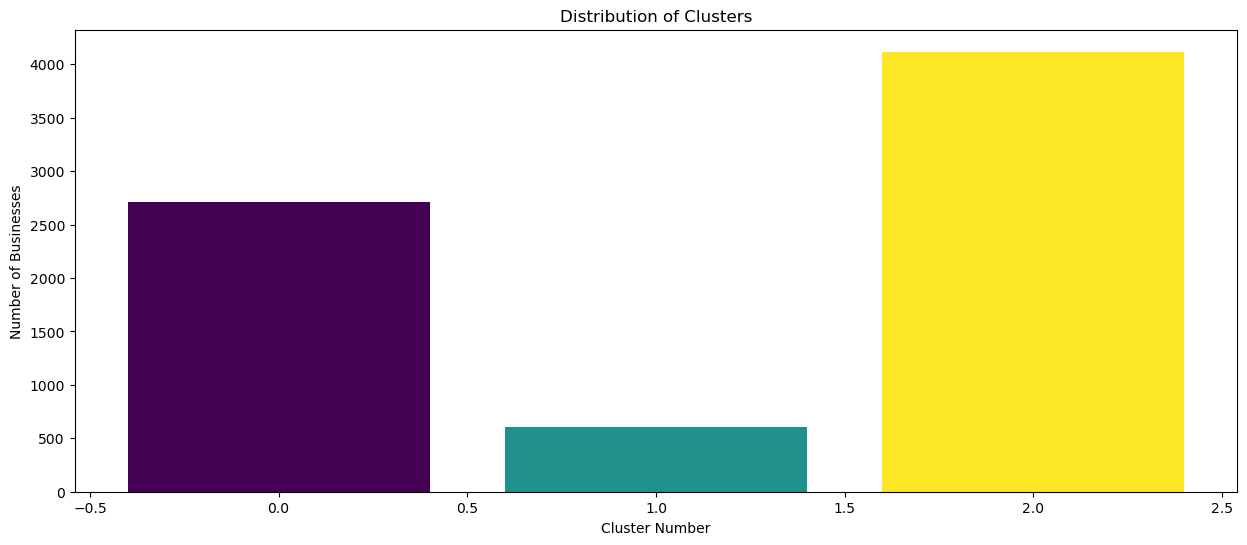

In [15]:
drawMap(X_train_pca, labels_gmm, category_colors)
CountClusters(labels_gmm, category_colors)

In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, labels_gmm)
labels_gmm_pred = rf.predict(X_val)

accuracy = accuracy_score(labels_gmm_val, labels_gmm_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


In [17]:
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

                     Feature  Importance
4        cat__continent_Asia    0.270495
14        cat__cluster_geo_2    0.231331
6      cat__continent_Europe    0.124585
12        cat__cluster_geo_0    0.084741
15        cat__cluster_geo_3    0.052553
13        cat__cluster_geo_1    0.052431
3     cat__continent_America    0.050463
7        cat__cluster_type_0    0.029565
9        cat__cluster_type_2    0.026762
10       cat__cluster_type_3    0.025179
11       cat__cluster_type_4    0.018039
8        cat__cluster_type_1    0.013883
17    remainder__has_website    0.007689
0          num__review_count    0.006682
5   cat__continent_Australia    0.002185
1                num__rating    0.001637
2      cat__continent_Africa    0.000898
16       remainder__verified    0.000884


In Gaussian Mixture Models we can see tha most important features are related to location and types.

In [18]:
X_train2 = X_train.copy()
X_train2['cluster'] = labels_gmm
grouped_X_train2 = X_train2[['cat__cluster_type_0', 'cat__cluster_type_1', 'cat__cluster_type_2', 
                            'cat__cluster_type_3', 'cat__cluster_type_4', 'cluster']].groupby('cluster').sum()
print("\nGrouped and Summed DataFrame:")
print(grouped_X_train2)


Grouped and Summed DataFrame:
         cat__cluster_type_0  cat__cluster_type_1  cat__cluster_type_2  \
cluster                                                                  
0                      100.0                481.0                139.0   
1                       97.0                 53.0                103.0   
2                        0.0                818.0                  0.0   

         cat__cluster_type_3  cat__cluster_type_4  
cluster                                            
0                       99.0               1888.0  
1                      107.0                241.0  
2                        2.0               3297.0  


In [12]:
df = pd.read_csv('./DATA/X_train_clean.csv')
unique_labels = np.unique(labels_gmm)

for label in unique_labels:
    cluster_data = df[labels_gmm == label]
    cluster_mean = cluster_data.mean()
    cluster_median = cluster_data.median()
    cluster_std = cluster_data.std()
    
    print(f"Cluster {label} Summary:")
    print("Mean:")
    print(cluster_mean)
    print("Median:")
    print(cluster_median)
    print("Standard Deviation:")
    print(cluster_std)
    print("\n")

Cluster 0 Summary:
Mean:
cat__continent_Africa        0.000000
cat__continent_America       0.000000
cat__continent_Asia          1.000000
cat__continent_Australia     0.000000
cat__continent_Europe        0.000000
cat__cluster_type_0          0.710908
cat__cluster_type_1          0.037614
cat__cluster_type_2          0.205535
cat__cluster_type_3          0.045943
cat__cluster_type_4          0.000000
cat__cluster_geo_0           0.000000
cat__cluster_geo_1           0.568243
cat__cluster_geo_2           0.000000
cat__cluster_geo_3           0.431757
remainder__latitude         25.377933
remainder__longitude        55.845889
remainder__review_count     38.465341
remainder__rating            4.275766
remainder__verified          0.647501
remainder__has_website       0.437668
dtype: float64
Median:
cat__continent_Africa        0.000000
cat__continent_America       0.000000
cat__continent_Asia          1.000000
cat__continent_Australia     0.000000
cat__continent_Europe        0.000000
ca